# Plots the Sea Surface Temperature (SST) anomaly map for the preceding month

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt

In [13]:
import os, sys
import numpy as np
from numpy import ma
from mpl_toolkits.basemap import Basemap
from matplotlib import cm

from netCDF4 import Dataset

from netcdftime import num2date
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [15]:
sys.path.append(os.path.join(os.environ['HOME'],'pythonlibs'))
import colormaps_functions as cf

### set proxies here if needed (and if notebook run by CRON)

In [14]:
#os.environ['http_proxy'] = 'url:port'
#os.environ['https_proxy'] = 'url:port'

### set up directories paths

In [6]:
# data 
dpath = os.path.join(os.environ['HOME'], 'data/SST/NOAA_hires_1981_present')

# figures
fpath = os.path.join(os.environ['HOME'], 'operational/ICU/supplement/SST/figures/')

### defines the geographical domain

In [ ]:
ll_lon = 135.
ur_lon = 240.
ll_lat = -50.
ur_lat = 10.

### defines the plotting function

In [35]:
def plot_SST_ICU_anoms_hires(lat,lon,data,vmin,vmax,step,cmap,title):
    fig = plt.figure(figsize=(9.5,4.9))
    ax = fig.add_axes([0.03,0.05,0.92,0.9])

    m = Basemap(projection='cyl', llcrnrlon=ll_lon, llcrnrlat=ll_lat, urcrnrlon=ur_lon, urcrnrlat=ur_lat, \
               resolution='c', ax=ax, area_thresh=50.)
    
    lons, lats = np.meshgrid(lon, lat)

    im = m.pcolormesh(lons, lats, data, vmin=vmin, vmax=vmax, cmap=cmap, latlon=True)

    cb = m.colorbar(im, ticks=np.arange(vmin,vmax+step,step), boundaries=np.arange(vmin,vmax+step,step), drawedges=True)
    
    cb.ax.set_yticklabels([str(x).rjust(3," ") for x in np.round(np.arange(vmin,vmax+step,step),1)])
    
    cb.ax.get_yticklabels()[10].set_visible(False)
    
    cb.set_label("degrees C.", fontsize=14)

    plt.title(title, fontsize=16)

    m.drawcoastlines(linewidth=1.0,color='k')
    m.fillcontinents(color='k')
    #draw parallels and meridians.
    delat = 10.
    circles = np.arange(-50.,10. + delat, delat)
    m.drawparallels(circles, labels=[1,0,0,0], fontsize=14, linewidth=0.8, color='k')
    delon = 10.
    meridians = np.arange(ll_lon,ur_lon, delon)
    m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=14, linewidth=0.8, color='k')
    return fig

### get today's date (UTC) and subtract one month

In [16]:
today = datetime.utcnow() 

In [17]:
dtdown = today - relativedelta(months=1)

### downloads the latest data (current year)

In [20]:
fname = "sst.day.mean.{}.v2.nc".format(dtdown.strftime("%Y"))

# if needed, proxy setting can be set here
#cmd = "curl --silent --proxy url:port ftp://ftp.cdc.noaa.gov/Datasets/noaa.oisst.v2.highres/{} -o {}"\
#.format(fname, os.path.join(dpath,fname))

cmd = "curl --silent --proxy www-proxy.niwa.co.nz:80 ftp://ftp.cdc.noaa.gov/Datasets/noaa.oisst.v2.highres/{} -o {}"\
.format(fname, os.path.join(dpath,fname))

os.system(cmd)

0

### load the climatology (monthly, established over 1982 - 2011)

In [21]:
with Dataset(os.path.join(dpath,'SP/sst.mon.clim.1982.2011.nc'), 'r') as nc: 
    sst_clim = nc.variables['sst'][:,:,:]

### loads the near real time data

In [22]:
with Dataset(os.path.join(dpath,fname),'r') as nc:
    time = nc.variables['time'][:]
    units = nc.variables['time'].units
    sst = nc.variables['sst'][:,:,:]
    lat = nc.variables['lat'][:]
    lon = nc.variables['lon'][:]
    time_hr = num2date(time,units)
    cal = np.squeeze([np.c_[x.year,x.month] for x in time_hr])

### selects the domain

In [23]:
ilat = np.where( (lat >= ll_lat) & (lat <= ur_lat) )[0]
ilon = np.where( (lon >= ll_lon) & (lon <= ur_lon) )[0]

lat = lat[ilat]
lon = lon[ilon]

sst = ma.take(ma.take(sst,ilon,axis=2),ilat,axis=1)

### select time, calculate monthly averages, calculate anomalies

In [24]:
sst = ma.take(sst,np.where(cal[:,1] == dtdown.month)[0], axis=0).mean(0)

sst_a = ma.subtract(sst,sst_clim[(dtdown.month - 1),:,:])

### plots the map

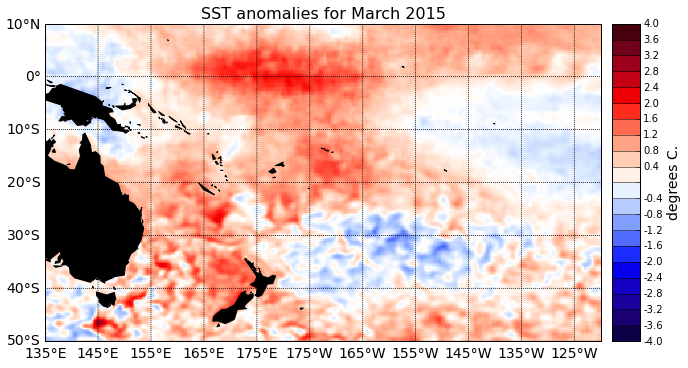

In [36]:
cmap = cf.gmtColormap("dkbluered")

f = plot_SST_ICU_anoms_hires(lat,lon,sst_a,-4.,4.,0.4,cmap,'SST anomalies for {}'.\
                         format(dtdown.strftime("%B %Y")))

### saves the figure

In [ ]:
f.savefig(os.path.join(fpath, "SST_anoms_{}.png".format(dtdown.strftime("%Y_%m"))), dpi=200)